In [44]:
import gym
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Implementing A2C

## Examine the env

In [45]:
env = gym.make('CartPole-v0')
print("State space : ",env.observation_space)
print("Action Space : ",env.action_space)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print("State size : ",state_size)
print("Action size : ",action_size)

State space :  Box(4,)
Action Space :  Discrete(2)
State size :  4
Action size :  2


### Watching an agent taking random action

In [46]:
state = env.reset()
rewards = 0 
while True:
    action= env.action_space.sample()
    env.render()
    state,reward,done,_ = env.step(action)
    rewards+=reward
    if done:
        break
print("Score : ",rewards)

Score :  20.0


## Building the Neural Network

In [5]:
class Network(nn.Module):
    def __init__(self,input_size,action_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size,16)
        self.fc2 = nn.Linear(16,8)
        self.actor = nn.Linear(8,action_size)
        self.critic = nn.Linear(8,1)
    def forward(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actor = F.softmax(self.actor(x),dim=1)
        critic = self.critic(x)
        return actor,critic

In [51]:
model = Network(state_size,action_size)
optimizer = optim.Adam(model.parameters(),lr=0.001)

### Running the untrained Network

In [52]:
rewards = 0
state = env.reset()
while True:
    action,_ = model(state)
    action = np.argmax(action.detach().numpy())
    state,reward,done,_ = env.step(action)
    env.render()
    rewards+=reward
    if done:
        break
print("Total Score : ",rewards)

Total Score :  8.0


## Actor-Critic Algorithm (A2C)

In [58]:
n_episodes = 3000
gamma = 0.99
reward_per_ep = []
for i in range(n_episodes):
    state = env.reset()
    scores = []
    values = []
    log_probs = []
    while True:
        policy_dist,value = model(state)
        value = value.detach().numpy()[0,0]
        values.append(value)
        dist = policy_dist.detach().numpy() 
        action = np.random.choice(action_size, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        log_probs.append(log_prob)
        n_state,reward,done,_ = env.step(action)
        scores.append(reward)
        state = n_state
        if done:
            policy_dist,value = model(state)
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            log_probs.append(log_prob)
            value = value.detach().numpy()[0,0]
            values.append(value)
            break
        
    reward_per_ep.append(np.sum(scores))
    # Calculating the Q value 
    Q_vals = np.zeros_like(values)
    temp=0
    for j in reversed(range(len(scores))):
        temp = scores[j]+gamma*temp
        Q_vals[j] = temp

    values = torch.FloatTensor(values)
    Q_vals = torch.FloatTensor(Q_vals)
    advantage = Q_vals-values
    log_probs = torch.tensor(log_probs,requires_grad=True)
    # Loss 
    actor_loss = (-log_probs*advantage).mean()
    critic_loss = (0.5*advantage**2).mean()

    ac_loss = actor_loss+critic_loss

    optimizer.zero_grad()
    ac_loss.backward()
    optimizer.step()
    print("\rEpisode {}  avg reward : {:3f} ".format((i+1),np.mean(reward_per_ep)),end="")

Episode 3000  avg reward : 20.791333 

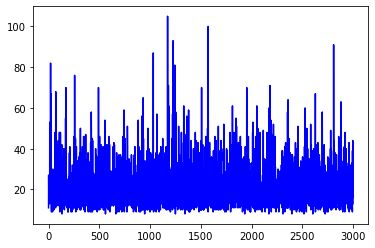

In [57]:
plt.plot(np.arange(len(reward_per_ep)),reward_per_ep,Color='b')
plt.show()